# Ethan Holand HW3 Problem 2

In [321]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures # Important new include
from sklearn.model_selection import KFold # Important new include

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [322]:
# Define variables
n = 10 # dimensionality of the data
N_train = 50
N_test = 1000


a = np.random.rand(n,1) # an arbitrary non-zero n-dimensional vector
mu = np.random.rand(n) # some non-zero value, dimension = n
Sigma = np.random.rand(1)*np.eye(n,n) # non-diagonal covariance matrix, dimension = n


# Hyperparameters
alpha = 1 #hyperparameter, to be tweaked later

In [323]:
# Generate N_train datapoints from mu, sigma
X_train = mvn.rvs(mu, Sigma, N_train)
X_valid = mvn.rvs(mu, Sigma, N_test)

z_train = mvn.rvs(np.zeros(n), alpha*np.eye(n), N_train) # 10 dimensional noise, Ntrain samples from a 0-mean αI-covariance-matrix Gaussian pdf.
z_valid = mvn.rvs(np.zeros(n), alpha*np.eye(n), N_test) # 10 dimensional noise, Ntrain samples from a 0-mean αI-covariance-matrix Gaussian pdf.

v_train = mvn.rvs(np.zeros(1), np.eye(1), N_train) # N_train samples from a 0-mean unit-variance Gaussian pdf)
v_valid = mvn.rvs(np.zeros(1), np.eye(1), N_test) # N_train samples from a 0-mean unit-variance Gaussian pdf)

In [324]:
y_train = (a.T.dot((X_train+z_train).T)+v_train).T
y_valid = (a.T.dot((X_valid+z_valid).T)+v_valid).T

In [325]:
def analytical_solution_map(X, y, gamma):
    n = np.size(np.asarray(X), axis=1)
    # Analytical solution is (X^T*X+gamma*I)^-1 * X^T * y 
    return np.linalg.inv(X.T.dot(X)+gamma*np.eye(n)).dot(X.T).dot(y)

def mse(y_preds, y_true):
    # Residual error (X * theta) - y
    error = y_preds - y_true
    # Loss function is MSE
    return np.mean(error ** 2)

The best hyperparameter value is: beta=1.1233240329780266e-07


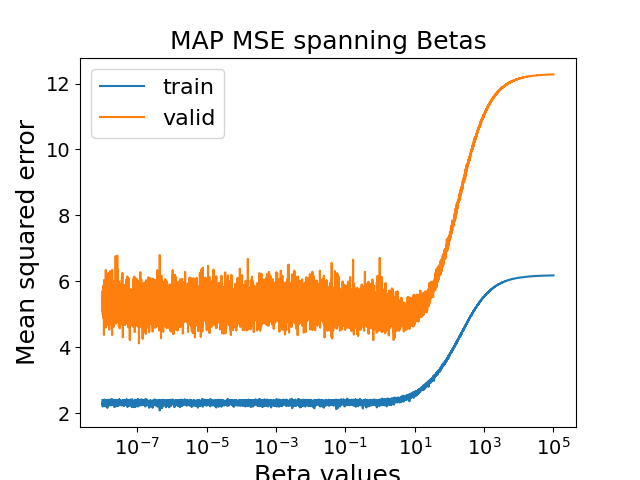

In [326]:
# Polynomial degrees ("hyperparameters") to evaluate 
betas = np.geomspace(10e-9, 10e4, 10000)
n_betas = np.size(betas)

# Number of folds for CV
K = 5

# STEP 1: Partition the dataset into K approximately-equal-sized partitions
# Shuffles data before doing the division into folds (not necessary, but a good idea)
kf = KFold(n_splits=K, shuffle=True) 

# Allocate space for CV
# No need for training loss storage too but useful comparison
mse_valid_mk = np.empty((n_betas, K)) 
mse_train_mk = np.empty((n_betas, K)) # Indexed by model m, data partition k


index = 0
# STEP 2: Try all polynomial orders between 1 (best line fit) and 21 (big time overfit) M=2
for beta in betas:
    # K-fold cross validation
    k = 0
    # NOTE that these subsets are of the TRAINING dataset
    # Imagine we don't have enough data available to afford another entirely separate validation set
    for train_indices, valid_indices in kf.split(X_train):
        # Extract the training and validation sets from the K-fold split
        X_train_k = X_train[train_indices]
        y_train_k = y_train[train_indices]
        X_valid_k = X_valid[valid_indices]
        y_valid_k = y_valid[valid_indices]
        
        # Train model parameters
        X_train_k_poly = np.column_stack((np.ones(np.size(X_train_k, axis=0)), X_train_k))
        theta_mk = analytical_solution_map(X_train_k_poly, y_train_k, beta)
        
        # Validation fold polynomial transformation
        X_valid_k_poly = np.column_stack((np.ones(np.size(X_valid_k, axis=0)), X_valid_k))

        # Make predictions on both the training and validation set
        y_train_k_pred = X_train_k_poly.dot(theta_mk)        
        y_valid_k_pred = X_valid_k_poly.dot(theta_mk)

        # Record MSE as well for this model and k-fold
        mse_train_mk[index, k] = mse(y_train_k_pred, y_train_k)
        mse_valid_mk[index, k] = mse(y_valid_k_pred, y_valid_k)
        k += 1
    index += 1


            
# STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
mse_valid_m = np.mean(mse_valid_mk, axis=1) 

# +1 as the index starts from 0 while the degrees start from 1
optimal_beta = betas[np.argmin(mse_valid_m)]
print("The best hyperparameter value is: beta={}".format(optimal_beta))


fig, ax = plt.subplots()
plt.plot(betas, mse_train_m, label="train")
plt.plot(betas, mse_valid_m, label="valid")
ax.set_xscale('log')
plt.xlabel('Beta values')
plt.ylabel('Mean squared error')
plt.title('MAP MSE spanning Betas')
plt.legend()

# STEP 4: Re-train using your optimally selected model (degree=3) and deploy!!
# ...

In [327]:
X_train_augment = np.column_stack((np.ones(N_train), X_train))
theta_opt_map = analytical_solution_map(X_train_augment, y_train, optimal_beta)
analytical_preds = X_train_augment.dot(theta_opt_map)
gammas_mse = -2/optimal_beta*mse(analytical_preds, y_train)
print(gammas_mse)

-44872767.95554982


In [328]:
def k_fold_analysis(alpha, K):
    # Generate N_train datapoints from mu, sigma
    X_train = mvn.rvs(mu, Sigma, N_train)
    X_valid = mvn.rvs(mu, Sigma, N_test)

    z_train = mvn.rvs(np.zeros(n), alpha*np.eye(n), N_train) # 10 dimensional noise, Ntrain samples from a 0-mean αI-covariance-matrix Gaussian pdf.
    z_valid = mvn.rvs(np.zeros(n), alpha*np.eye(n), N_test) # 10 dimensional noise, Ntrain samples from a 0-mean αI-covariance-matrix Gaussian pdf.

    v_train = mvn.rvs(np.zeros(1), np.eye(1), N_train) # N_train samples from a 0-mean unit-variance Gaussian pdf)
    v_valid = mvn.rvs(np.zeros(1), np.eye(1), N_test) # N_train samples from a 0-mean unit-variance Gaussian pdf)



    y_train = (a.T.dot((X_train+z_train).T)+v_train).T
    y_valid = (a.T.dot((X_valid+z_valid).T)+v_valid).T



    # Polynomial degrees ("hyperparameters") to evaluate 
    betas = np.geomspace(10e-9, 10e4, 100)
    n_betas = np.size(betas)

    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    # Shuffles data before doing the division into folds (not necessary, but a good idea)
    kf = KFold(n_splits=K, shuffle=True) 

    # Allocate space for CV
    # No need for training loss storage too but useful comparison
    mse_valid_mk = np.empty((n_betas, K)) 
    mse_train_mk = np.empty((n_betas, K)) # Indexed by model m, data partition k


    index = 0
    # STEP 2: Try all polynomial orders between 1 (best line fit) and 21 (big time overfit) M=2
    for beta in betas:
        # K-fold cross validation
        k = 0
        # NOTE that these subsets are of the TRAINING dataset
        # Imagine we don't have enough data available to afford another entirely separate validation set
        for train_indices, valid_indices in kf.split(X_train):
            # Extract the training and validation sets from the K-fold split
            X_train_k = X_train[train_indices]
            y_train_k = y_train[train_indices]
            X_valid_k = X_valid[valid_indices]
            y_valid_k = y_valid[valid_indices]
            
            # Train model parameters
            X_train_k_poly = np.column_stack((np.ones(np.size(X_train_k, axis=0)), X_train_k))
            theta_mk = analytical_solution_map(X_train_k_poly, y_train_k, beta)
            
            # Validation fold polynomial transformation
            X_valid_k_poly = np.column_stack((np.ones(np.size(X_valid_k, axis=0)), X_valid_k))

            # Make predictions on both the training and validation set
            y_train_k_pred = X_train_k_poly.dot(theta_mk)        
            y_valid_k_pred = X_valid_k_poly.dot(theta_mk)

            # Record MSE as well for this model and k-fold
            mse_train_mk[index, k] = mse(y_train_k_pred, y_train_k)
            mse_valid_mk[index, k] = mse(y_valid_k_pred, y_valid_k)
            k += 1
        index += 1

                
    # STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
    # mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
    mse_valid_m = np.mean(mse_valid_mk, axis=1) 

    # +1 as the index starts from 0 while the degrees start from 1
    optimal_beta = betas[np.argmin(mse_valid_m)]
    # print("The best hyperparameter value is: beta={}".format(optimal_beta))


    # plt.plot(betas, mse_train_m, label="train")
    plt.plot(betas, mse_valid_m, label="alpha={:.2f}".format(alpha))
    # ax.set_xscale('log')
    # plt.xlabel('Beta values')
    # plt.ylabel('Mean squared error')
    # plt.title('MAP MSE spanning Betas')
    # plt.legend()

    # STEP 4: Re-train using your optimally selected model (degree=3) and deploy!!
    X_train_augment = np.column_stack((np.ones(N_train), X_train))
    theta_opt_map = analytical_solution_map(X_train_augment, y_train, optimal_beta)
    analytical_preds = X_train_augment.dot(theta_opt_map)
    score = -2/optimal_beta*mse(analytical_preds, y_train)
    

    return score, optimal_beta

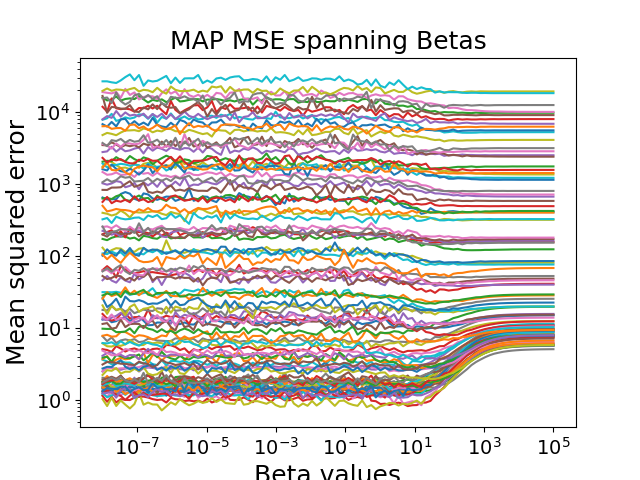

In [329]:
alphas = np.geomspace(10e-3*np.trace(Sigma)/n, 10e3*np.trace(Sigma)/n, 100)

K = 5
scores = np.zeros(np.size(alphas))

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Beta values')
plt.ylabel('Mean squared error')
plt.title('MAP MSE spanning Betas')

for i in range(0, np.size(alphas)):
    scores[i] = k_fold_analysis(alphas[i], K)[0]


# ax.legend()

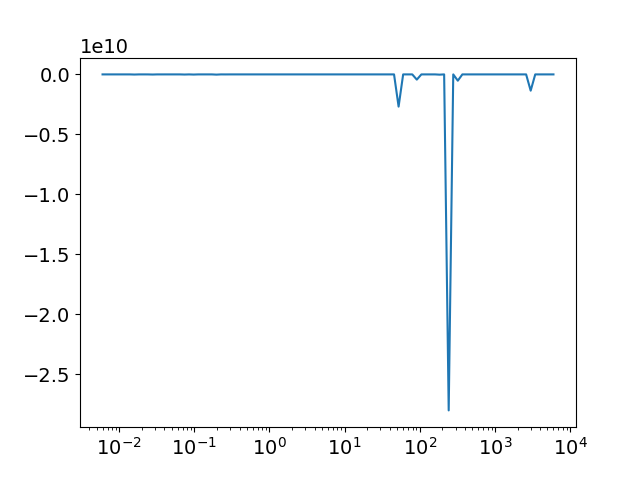

In [330]:
alphas = np.geomspace(10e-3*np.trace(Sigma)/n, 10e3*np.trace(Sigma)/n, 100)

K = 5

scores = np.zeros(np.size(alphas))

for i in range(0, np.size(alphas)):
    scores[i] = k_fold_analysis(alphas[i], K)[0]


fig, ax = plt.subplots()
ax.set_xscale('log')
plt.plot(alphas, scores)

In [331]:
# fig, ax = plt.subplots()
# ax.set_xscale('log')
# plt.plot(alphas, scores)